<a href="https://colab.research.google.com/github/Sid-2004/Research-Paper--WallStreetsBets-ML-Emotional-Sentiment/blob/main/Research_Paper_FinTech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install praw yfinance transformers torch tensorflow keras-tcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 2.0 MB/s eta 0:00:00


In [2]:
# ---------------------------
# 0. Setup: installs & imports
# ---------------------------
!pip install praw transformers sentence-transformers yfinance pytorch-lightning pytorch-forecasting==0.10.4 torchinfo
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  # CPU fallback if GPU not available

# Standard imports
import os, re, time, math, json, datetime
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import networkx as nx
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import yfinance as yf


ERROR: Ignored the following versions that require a different python version: 0.10.2 Requires-Python >=3.8,<3.11; 0.10.3 Requires-Python >=3.8,<3.11; 1.0.0 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement pytorch-forecasting==0.10.4 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.3.0, 0.3.1, 0.4.0, 0.4.1, 0.5.0, 0.5.1, 0.5.2, 0.5.3, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.8.0, 0.8.1, 0.8.2, 0.8.3, 0.8.4, 0.8.5, 0.9.0, 0.9.1, 0.9.2, 0.10.0, 0.10.1, 1.1.0, 1.1.1, 1.2.0, 1.3.0, 1.4.0)
ERROR: No matching distribution found for pytorch-forecasting==0.10.4
Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
!pip install praw yfinance transformers torch tensorflow keras-tcn
import praw
import pandas as pd

In [4]:
reddit = praw.Reddit(client_id="gpXjQ2OtfofKUYW-rcMJrw",
client_secret="TfeCSLEoqahvSnikIFDYXdAavE7qww",
user_agent="my_wsb_scraper/0.1 by your_momsbob_is_mine"
)
subreddit = reddit.subreddit("wallstreetbets")

# Example: Get top 100 posts from this week
posts = []
for submission in subreddit.top(limit=100, time_filter="week"):
    posts.append({
        "title": submission.title,
        "text": submission.selftext,
        "score": submission.score,
        "comments": submission.num_comments
    })

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [5]:
df = pd.DataFrame(posts)
df.head()

,title,text,score,comments
0,"$10,000 of Intel bought 25 years ago is worth ...",,47174,971
1,I know exactly what’s coming…,,16372,491
2,"oops, it is the market",,8799,137
3,Tax refund 3k to 300k,5 months ago in april i decided to use my tax ...,7925,581
4,I did it… AGAIN.. $100 into $7k $INTC calls,Congrats and fck me \n\nGoodbye! 👋,7509,720


In [6]:
df.tail()

,title,text,score,comments
95,"Daily Discussion Thread for September 19, 2025",This post contains content not supported on ol...,197,9163
96,"$LDI - update: Added 25k shares, holding","NFA, DYOR.\n\nPaperhands buys first, does his ...",197,106
97,Just hit £500k - ALL IN ON HUT 8,**Short background on my investing journey**\n...,192,97
98,I thought selling OKLO for a 7k gain was a sol...,Sold 6540 shares of OKLO littl over 8 bucks a ...,194,86
99,Weekend Discussion Thread for the Weekend of S...,This post contains content not supported on ol...,192,8435


In [7]:
df.to_csv("wsb_posts.csv",index=False)
df.head()

,title,text,score,comments
0,"$10,000 of Intel bought 25 years ago is worth ...",,47174,971
1,I know exactly what’s coming…,,16372,491
2,"oops, it is the market",,8799,137
3,Tax refund 3k to 300k,5 months ago in april i decided to use my tax ...,7925,581
4,I did it… AGAIN.. $100 into $7k $INTC calls,Congrats and fck me \n\nGoodbye! 👋,7509,720


In [10]:
import re
df=pd.read_csv("wsb_posts.csv")

def clean_text(text):
  if not isinstance(text, str):
    return ""
  text = text.lower()                           # lowercase
  text = re.sub(r"http\S+|www\S+", "", text)    # remove links
  text = re.sub(r"[^a-z\s]", "", text)          # remove punctuation/numbers
  text = re.sub(r"\s+", " ", text).strip()      # remove extra spaces
  return text

df["clean_text"] = df["title"].astype(str) + " " + df["text"].astype(str)
df["clean_text"] = df["clean_text"].apply(clean_text)

display(df.head())

,title,text,score,comments,clean_text
0,"$10,000 of Intel bought 25 years ago is worth ...",NaN,47174,971,of intel bought years ago is worth today nan
1,I know exactly what’s coming…,NaN,16372,491,i know exactly whats coming nan
2,"oops, it is the market",NaN,8799,137,oops it is the market nan
3,Tax refund 3k to 300k,5 months ago in april i decided to use my tax ...,7925,581,tax refund k to k months ago in april i decide...
4,I did it… AGAIN.. $100 into $7k $INTC calls,Congrats and fck me \n\nGoodbye! 👋,7509,720,i did it again into k intc calls congrats and ...


In [11]:
# ---------------------------
# 1. Data Collection (using PRAW)
# ---------------------------
import praw
import pandas as pd

# Replace with your own Reddit API credentials (from https://www.reddit.com/prefs/apps)
# Make sure to keep these secret!
reddit = praw.Reddit(client_id="gpXjQ2OtfofKUYW-rcMJrw",
                     client_secret="TfeCSLEoqahvSnikIFDYXdAavE7qww",
                     user_agent="my_wsb_scraper/0.1 by your_momsbob_is_mine")

subreddit = reddit.subreddit("wallstreetbets")

# Get a larger number of top posts from this week using PRAW
posts = []
# Increase the limit to get more posts, up to 1000
for submission in subreddit.top(limit=1000, time_filter="week"):
    posts.append({
        "title": submission.title,
        "text": submission.selftext,
        "score": submission.score,
        "comments": submission.num_comments
    })

df = pd.DataFrame(posts)
df.to_csv("wsb_posts_large.csv", index=False)
print(f"Saved {len(df)} posts to wsb_posts_large.csv")
display(df.head())

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Saved 266 posts to wsb_posts_large.csv


,title,text,score,comments
0,"$10,000 of Intel bought 25 years ago is worth ...",,47176,971
1,I know exactly what’s coming…,,16374,491
2,"oops, it is the market",,8807,137
3,Tax refund 3k to 300k,5 months ago in april i decided to use my tax ...,7936,581
4,I did it… AGAIN.. $100 into $7k $INTC calls,Congrats and fck me \n\nGoodbye! 👋,7514,720


**Reasoning**:
Initialize the PRAW Reddit object and retrieve a smaller number of top posts from the specified subreddit, then store the relevant data in a DataFrame.



In [12]:
reddit = praw.Reddit(client_id="gpXjQ2OtfofKUYW-rcMJrw",
client_secret="TfeCSLEoqahvSnikIFDYXdAavE7qww",
user_agent="my_wsb_scraper/0.1 by your_momsbob_is_mine"
)
subreddit = reddit.subreddit("wallstreetbets")

# Get a smaller number of top posts from this week
posts = []
for submission in subreddit.top(limit=50, time_filter="week"):
    posts.append({
        "title": submission.title,
        "text": submission.selftext,
        "score": submission.score,
        "comments": submission.num_comments
    })

df = pd.DataFrame(posts)
display(df.head())

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



,title,text,score,comments
0,"$10,000 of Intel bought 25 years ago is worth ...",,47183,971
1,I know exactly what’s coming…,,16381,491
2,"oops, it is the market",,8811,137
3,Tax refund 3k to 300k,5 months ago in april i decided to use my tax ...,7933,581
4,I did it… AGAIN.. $100 into $7k $INTC calls,Congrats and fck me \n\nGoodbye! 👋,7502,720


**Reasoning**:
Define the clean_text function, concatenate the title and text columns, apply the cleaning function, and display the head of the dataframe to verify the results.



In [13]:
import re

def clean_text(text):
  if not isinstance(text, str):
    return ""
  text = text.lower()                           # lowercase
  text = re.sub(r"http\S+|www\S+", "", text)    # remove links
  text = re.sub(r"[^a-z\s]", "", text)          # remove punctuation/numbers
  text = re.sub(r"\s+", " ", text).strip()      # remove extra spaces
  return text

df["clean_text"] = df["title"].astype(str) + " " + df["text"].astype(str)
df["clean_text"] = df["clean_text"].apply(clean_text)

display(df.head())

,title,text,score,comments,clean_text
0,"$10,000 of Intel bought 25 years ago is worth ...",,47183,971,of intel bought years ago is worth today
1,I know exactly what’s coming…,,16381,491,i know exactly whats coming
2,"oops, it is the market",,8811,137,oops it is the market
3,Tax refund 3k to 300k,5 months ago in april i decided to use my tax ...,7933,581,tax refund k to k months ago in april i decide...
4,I did it… AGAIN.. $100 into $7k $INTC calls,Congrats and fck me \n\nGoodbye! 👋,7502,720,i did it again into k intc calls congrats and ...


## Analyze data

### Subtask:
Perform some basic analysis on the collected data.


In [14]:
#calculating and display the average score and number of comments and find the highest score and most comments
average_score = df['score'].mean()
average_comments = df['comments'].mean()

print(f"Average Score: {average_score:.2f}")
print(f"Average Comments: {average_comments:.2f}")

highest_score_post = df.loc[df['score'].idxmax()]
most_comments_post = df.loc[df['comments'].idxmax()]

print("\nPost with Highest Score:")
display(highest_score_post)

print("\nPost with Most Comments:")
display(most_comments_post)

Average Score: 3536.90
Average Comments: 271.08

Post with Highest Score:


,0
title,"$10,000 of Intel bought 25 years ago is worth ..."
text,
score,47183
comments,971
clean_text,of intel bought years ago is worth today



Post with Most Comments:


,0
title,"$10,000 of Intel bought 25 years ago is worth ..."
text,
score,47183
comments,971
clean_text,of intel bought years ago is worth today


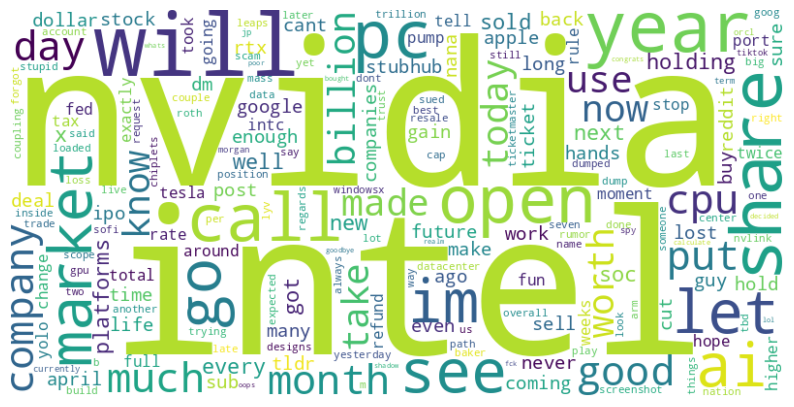

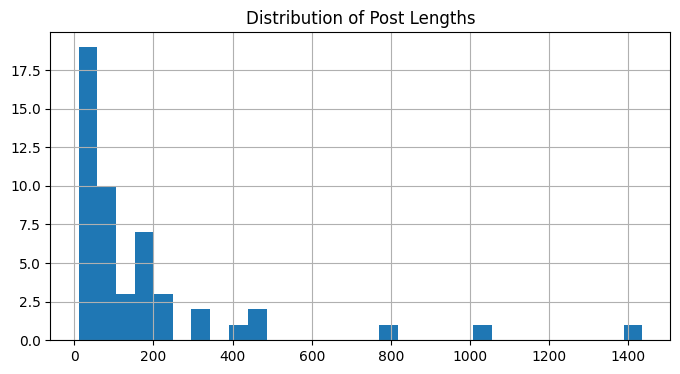

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word cloud
text = " ".join(df["clean_text"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Post length distribution
df["length"] = df["clean_text"].apply(len)
df["length"].hist(bins=30, figsize=(8,4))
plt.title("Distribution of Post Lengths")
plt.show()


In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Apply VADER
df["vader_score"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["vader_sentiment"] = df["vader_score"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

df["vader_sentiment"].value_counts()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,count
vader_sentiment,
positive,24
negative,14
neutral,12


In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load FinBERT
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply FinBERT sentiment analysis
def get_finbert_sentiment(text):
    if not text.strip():
        return "neutral"
    result = finbert_pipeline(text[:512])[0]  # truncate long posts
    return result["label"]

df["finbert_sentiment"] = df["clean_text"].apply(get_finbert_sentiment)
df["finbert_sentiment"].value_counts()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu


,count
finbert_sentiment,
neutral,40
negative,8
positive,2


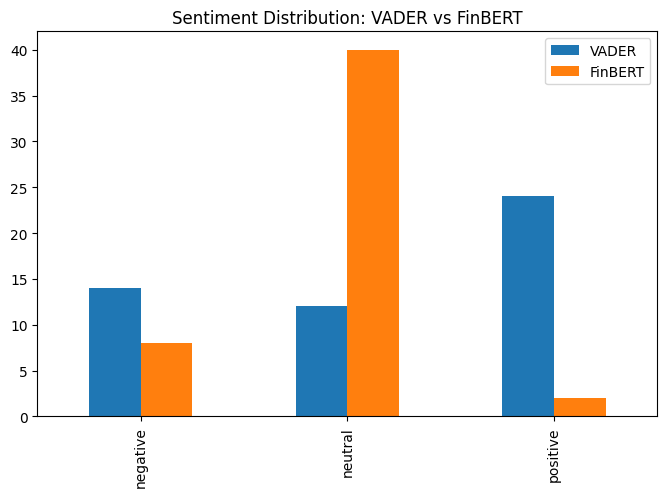

In [22]:
import matplotlib.pyplot as plt

comparison = pd.DataFrame({
    "VADER": df["vader_sentiment"].value_counts(),
    "FinBERT": df["finbert_sentiment"].value_counts()
}).fillna(0)

comparison.plot(kind="bar", figsize=(8,5))
plt.title("Sentiment Distribution: VADER vs FinBERT")
plt.show()

In [23]:
df[["clean_text", "vader_sentiment", "finbert_sentiment"]].head(20)


,clean_text,vader_sentiment,finbert_sentiment
0,of intel bought years ago is worth today,positive,neutral
1,i know exactly whats coming,neutral,neutral
2,oops it is the market,neutral,neutral
3,tax refund k to k months ago in april i decide...,positive,neutral
4,i did it again into k intc calls congrats and ...,positive,neutral
5,poor guy is in the shadow realm this guy lost ...,negative,neutral
6,elon musk purchases about billion worth of tes...,positive,neutral
7,higher unemployment is bullish,negative,negative
8,intel is saved nana can rest now nvidia and in...,positive,positive
9,fed cuts fed funds rate by to,negative,negative


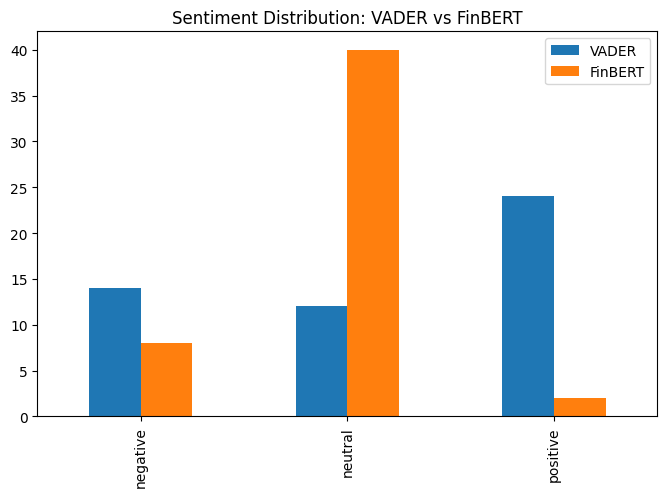

,VADER,FinBERT
negative,14,8
neutral,12,40
positive,24,2


In [24]:
import matplotlib.pyplot as plt

comparison = pd.DataFrame({
    "VADER": df["vader_sentiment"].value_counts(),
    "FinBERT": df["finbert_sentiment"].value_counts()
}).fillna(0)

comparison.plot(kind="bar", figsize=(8,5))
plt.title("Sentiment Distribution: VADER vs FinBERT")
plt.show()

comparison
